Plot shear dispersion and mean flow suppression results.

In [1]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm
from matplotlib.ticker import LogFormatter
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize_scalar

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [2]:
def get_colors_from_cmap(cmap_name, n_colors):
    cmap = cm.get_cmap(cmap_name)
    return [cmap(i / (n_colors - 1)) for i in range(n_colors)]

blues   = get_colors_from_cmap('Blues', 10)
reds = ['#f69a8b', '#b91a38']
greys = get_colors_from_cmap('Greys', 10)

colorlist_p5 = [blues[4], reds[0]]
colorlist_p25 = [blues[8], reds[1]]
colorlist_p03125 = [greys[3], greys[5], 'k']

/state/partition1/job-65613382/ipykernel_2705759/3569882092.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


### Regions

In [3]:
def SubTrop_slice(ds):

    xh_min = 46
    yh_min = -22

    return ds.sel(xh = slice(xh_min, xh_min + 6), yh = slice(yh_min, yh_min + 6))  

def SubPol_slice(ds):

    xh_min = 46
    yh_min = 52
    
    return ds.sel(xh = slice(xh_min, xh_min + 6), yh = slice(yh_min, yh_min + 6))
    
def ACC_slice(ds):

    xh_min = 46
    yh_min = -54

    return ds.sel(xh = slice(xh_min, xh_min + 6), yh = slice(yh_min, yh_min + 6))

### Shear dispersion functions

In [4]:
def calc_eigvecs(K):
    K_T = np.moveaxis(K.values, -2, -1)
    S = 0.5 * (K.values + K_T)

    evecs = xr.zeros_like(K)
    x, y, z = evecs.shape[0], evecs.shape[1], evecs.shape[2]

    for i in range(x):
        for j in range(y):
            for k in range(z):
                eigvals, eigvecs = la.eig(S[i, j, k, :, :])

                indmax = np.abs(eigvals).argmax()
                indmin = np.abs(eigvals).argmin()

                evecs[i, j, k][:, 0] = eigvecs[:, indmax]
                evecs[i, j, k][:, 1] = eigvecs[:, indmin]

    return evecs

def calc_shear_dispersion_kappa(ds, ds_h, grid, static, slice_func, res):
    ### Shear dispersion coefficient ###                                                                                                                           
    
    # Time average                                                                                                                                                 
    U = slice_func(grid.interp(ds.u.mean('time'), axis = 'X'))
    V = slice_func(grid.interp(ds.v.mean('time'), axis = 'Y'))
    
    # Depth average                                                                                                                                                
    h = slice_func(ds_h)
    U = (U * h).sum('zl') / h.sum('zl')
    V = (V * h).sum('zl') / h.sum('zl')
    
    # Differentiate                                                                                                                                                
    Re = 6.37e6
    lat = slice_func(static['geolat'])
    Udy = U.differentiate('yh') * 360 / (2 * np.pi * Re)
    Vdx = V.differentiate('xh') * 360 / (2 * np.pi * Re * np.cos(lat * np.pi / 180))
    
    # Compute scales
    coarsen_scale = int(2 / res)
    
    U2_scale = (U ** 2 + V ** 2).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean()
    L2_scale = U2_scale / (Udy ** 2 + Vdx ** 2).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean()
    
    ### MLT ###                                                                                                                                                    
    gamma = 0.35
    EKEBT = calc_EKEBT(ds, ds_h, grid, slice_func)
    L = calc_length(ds, static, slice_func)
    kappa_MLT = (gamma * np.sqrt(2 * EKEBT) * L).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean()
    
    ### Shear-dispersion ###
    kappa_SD = U2_scale * L2_scale / kappa_MLT

    return kappa_SD.load()

def calc_EKEBT(ds, ds_h, grid, slice_func):

    u = slice_func(grid.interp(ds.u, axis = 'X'))
    v = slice_func(grid.interp(ds.v, axis = 'Y'))
    h = slice_func(ds_h)

    up = u - u.mean('time')
    vp = v - v.mean('time')

    EKE = 0.5 * (up ** 2 + vp ** 2).mean('time')
    EKE_int = (EKE * h).sum('zl') / h.sum('zl')

    return EKE_int

def calc_length(ds, static, slice_func):
    '''
    Calculates energy containing scale
    '''
    Re = 6.37e6

    h = slice_func(ds.h)
    D = slice_func(static.depth_ocean)
    
    ssh = h.isel(zl = slice(0, None)).sum('zl', skipna = False) - D
    ssh_clim = ssh.mean('time')
    ssh_anom = ssh - ssh_clim

    lat = slice_func(static['geolat'])
    ssh_anom_dx = ssh_anom.differentiate('xh') * 360 / (2 * np.pi * Re * np.cos(lat * np.pi / 180))
    ssh_anom_dy = ssh_anom.differentiate('yh') * 360 / (2 * np.pi * Re)

    le = np.sqrt((ssh_anom ** 2).mean('time') / (ssh_anom_dx ** 2 + ssh_anom_dy ** 2).mean('time'))

    return le

### Mixing suppression functions

In [12]:
def calc_EKE(ds, grid, slice_func):
    '''
    Calculates time-mean EKE field   
    '''
    u = slice_func(grid.interp(ds.u, axis = 'X'))
    v = slice_func(grid.interp(ds.v, axis = 'Y'))
    
    up = u - u.mean('time')
    vp = v - v.mean('time')
    
    return (up ** 2 + vp ** 2).mean('time') / 2

def calc_Ubc_mean_flow(ds, ds_h, grid, slice_func):
    '''
    Calculates time-mean baroclinic zonal flow
    '''

    U = slice_func(grid.interp(ds.u.mean('time'), axis = 'X')) 
    h = slice_func(ds_h)
    
    return U - (U * h).sum('zl') / h.sum('zl')

def calc_Vbc_mean_flow(ds, ds_h, grid, slice_func):
    '''
    Calculates time-mean baroclinic meridional flow
    '''

    V = slice_func(grid.interp(ds.v.mean('time'), axis = 'Y')) 
    h = slice_func(ds_h)
    
    return V - (V * h).sum('zl') / h.sum('zl')

def calc_betaLd2(static, slice_func):
    # Calculate beta * L_d^2
    Re = 6.37e6
    Omega = 7.29e-5
    lat = slice_func(static['geolat'])
    
    beta = 2 * Omega * np.cos(lat * np.pi / 180) / Re
    Ld = Rd.interp_like(slice_func(static['area_t']))

    return (beta * Ld ** 2)


def calc_MLT_SMLT(ds, ds_h, kappa2, K, static, grid, slice_func, res):

    coarsen_scale = int(2 / res)

    # Calculate fields in suppression function
    EKE = calc_EKE(ds, grid, slice_func).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()
    le = 0*EKE + calc_length(ds, static, slice_func).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()
    Ubc = 0*EKE + calc_Ubc_mean_flow(ds, ds_h, grid, slice_func).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()
    Vbc = 0*EKE + calc_Vbc_mean_flow(ds, ds_h, grid, slice_func).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()
    betaLd2 = 0*EKE + calc_betaLd2(static, slice_func).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()
    h = slice_func(ds_h).coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean().T.load()

    # Project fields onto eigenvectors
    evecs_maj = calc_eigvecs(slice_func(K)).isel(col = 0)
    Ubc_proj = Ubc * evecs_maj.isel(row = 0) + Vbc * evecs_maj.isel(row = 1)
    betaLd2_proj = betaLd2 * evecs_maj.isel(row = 0)

    # Compute fields to fit
    kappa2 = slice_func(kappa2)

    # Define suppression function to fit
    def model(tau_day, EKE, le, Ubc, betaLd2):
        gamma = 0.35
        tau = tau_day * 86400
        kappa_MLT = gamma * np.sqrt(2 * EKE) * le
        
        S = 1 / (1 + (tau ** 2 / le ** 2 * (Ubc + betaLd2) ** 2))
        
        kappa_SMLT = kappa_MLT * S
        
        return kappa_SMLT
    
    def objective(c):
        pred = model(c, EKE.values.flatten(), le.values.flatten(), Ubc_proj.values.flatten(), betaLd2_proj.values.flatten())
        
        return np.sum(h.values.flatten() * (kappa2.values.flatten() - pred) ** 2)

    # Minimize
    optimal_tau = (minimize_scalar(objective, bounds = (0, 100), method = 'bounded')).x
    print(f'optimal tau: {optimal_tau:.4f} days')

    SMLT = model(optimal_tau, EKE, le, Ubc_proj, betaLd2_proj)
    MLT = 0.35 * (np.sqrt(2 * EKE) * le)
    
    return SMLT, MLT

def plotting_h(h, static, slice_func):
    h = slice_func(h).load()
    D = slice_func(static.depth_ocean).load()
    xh = h.xh.values
    yh = h.yh.values
    zi = np.linspace(1, 16, 16)
    shape = (zi.size, yh.size, xh.size)
    e = xr.DataArray(data = np.zeros(shape),
                     dims = ['zi', 'yh', 'xh'], 
                     coords = {'xh' : xh, 'yh' : yh, 'zi' : zi}).rename('eta')
    for k in range(zi.size):
        e[k, :, :] = h.isel(zl = slice(k, None)).sum('zl', skipna = False) - D

    e_c = 0.5 * (e.values[1:, :, :] + e.values[:-1, :, :]) + 0. * h
    return e_c

### Import data 

In [6]:
root = '/scratch/mp6191/NW2_TracerBackscatter'

# p5
exp = '/p5_SQGBS_KHTR0_2'
p5_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p5_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p5_SQGBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1
p5_SQGBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2
p5_SQGBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p5_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p5_grid = Grid(p5_SQGBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                   'Y': {'center': 'yh', 'outer': 'yq'}})

# p25
exp = '/p25_SQGBS_2'
p25_SQGBS = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False)
p25_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p25_SQGBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1
p25_SQGBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2
p25_SQGBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p25_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p25_grid = Grid(p25_SQGBS, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                   'Y': {'center': 'yh', 'outer': 'yq'}})

# ref
exp = '/p03125_2'
p03125 = xr.open_mfdataset(root + exp + '/snapshots*.nc', decode_times = False).isel(time = slice(None, 180))
p03125_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time')
p03125_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1
p03125_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2
p03125_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p03125_kappaSD_ACC = xr.open_dataset(root + exp + '/kappa_SD_ACC.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_kappaSD_SubPol = xr.open_dataset(root + exp + '/kappa_SD_SubPol.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_kappaSD_SubTrop = xr.open_dataset(root + exp + '/kappa_SD_SubTrop.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_EKE_ACC = xr.open_dataset(root + exp + '/EKE_ACC.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_EKE_SubPol = xr.open_dataset(root + exp + '/EKE_SubPol.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_EKE_SubTrop = xr.open_dataset(root + exp + '/EKE_SubTrop.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_le = xr.open_dataset(root + exp + '/EddyLength.nc', decode_times = False)['Le']

p03125_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)
p03125_grid = Grid(p03125_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                            'Y': {'center': 'yh', 'outer': 'yq'}})

Rd = xr.open_mfdataset(root + '/p5_noBS_KHTR2400Var/snapshots*.nc', decode_times = False).Rd1.isel(time = -1)

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

### Shear dispersion computations

In [7]:
### Compute shear dispersion and kappa1 over the three regions

## p5
res = 0.5
ds = p5_SQGBS
ds_h = p5_SQGBS_h
kappa1 = p5_SQGBS_kappa1.T

# SubTrop
slice_func = SubTrop_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p5_SQGBS_kappa1_SubTrop = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()#.mean(['xh', 'yh']).load()
p5_SQGBS_kappaSD_SubTrop = calc_shear_dispersion_kappa(ds, ds_h, p5_grid, p5_static, slice_func, res)#.mean(['xh', 'yh']).load()

# SubPol
slice_func = SubPol_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p5_SQGBS_kappa1_SubPol = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()#.mean(['xh', 'yh']).load()
p5_SQGBS_kappaSD_SubPol = calc_shear_dispersion_kappa(ds, ds_h, p5_grid, p5_static, slice_func, res)#.mean(['xh', 'yh']).load()

# ACC
slice_func = ACC_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p5_SQGBS_kappa1_ACC = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()#.mean(['xh', 'yh']).load()
p5_SQGBS_kappaSD_ACC = calc_shear_dispersion_kappa(ds, ds_h, p5_grid, p5_static, slice_func, res)#.mean(['xh', 'yh']).load()

## p25
res = 0.25
ds = p25_SQGBS
ds_h = p25_SQGBS_h
kappa1 = p25_SQGBS_kappa1.T

# SubTrop
slice_func = SubTrop_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p25_SQGBS_kappa1_SubTrop = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()
p25_SQGBS_kappaSD_SubTrop = calc_shear_dispersion_kappa(ds, ds_h, p25_grid, p25_static, slice_func, res)#.mean(['xh', 'yh']).load()

# SubPol
slice_func = SubPol_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p25_SQGBS_kappa1_SubPol = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()
p25_SQGBS_kappaSD_SubPol = calc_shear_dispersion_kappa(ds, ds_h, p25_grid, p25_static, slice_func, res)#.mean(['xh', 'yh']).load()

# ACC
slice_func = ACC_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p25_SQGBS_kappa1_ACC = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()
p25_SQGBS_kappaSD_ACC = calc_shear_dispersion_kappa(ds, ds_h, p25_grid, p25_static, slice_func, res)#.mean(['xh', 'yh']).load()

## ref
res = 0.03125
ds_h = p03125_h
kappa1 = p03125_kappa1.T

# SubTrop
slice_func = SubTrop_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p03125_kappa1_SubTrop = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()

# SubPol
slice_func = SubPol_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p03125_kappa1_SubPol = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()

# ACC
slice_func = ACC_slice
h_coarse = slice_func(ds_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()
p03125_kappa1_ACC = ((slice_func(kappa1.T) * h_coarse).sum('zl') / h_coarse.sum('zl')).T.load()

### Mixing suppression computations

In [15]:
## p5
res = 0.5
ds = p5_SQGBS
ds_h = p5_SQGBS_h
kappa2 = p5_SQGBS_kappa2
K = p5_SQGBS_K
grid = p5_grid
static = p5_static

# SubPol
slice_func = SubPol_slice
p5_SQGBS_kappa2_SubPol = slice_func(kappa2)
p5_SQGBS_SMLT_SubPol, p5_SQGBS_MLT_SubPol = calc_MLT_SMLT(ds, ds_h, kappa2, K, static, grid, slice_func, res)

# ACC
slice_func = ACC_slice
p5_SQGBS_kappa2_ACC = slice_func(kappa2)
p5_SQGBS_SMLT_ACC, p5_SQGBS_MLT_ACC = calc_MLT_SMLT(ds, ds_h, kappa2, K, static, grid, slice_func, res)

## p25
res = 0.25
ds = p25_SQGBS
ds_h = p25_SQGBS_h
kappa2 = p25_SQGBS_kappa2
K = p25_SQGBS_K
grid = p25_grid
static = p25_static

# SubPol
slice_func = SubPol_slice
p25_SQGBS_kappa2_SubPol = slice_func(kappa2)
p25_SQGBS_SMLT_SubPol, p25_SQGBS_MLT_SubPol = calc_MLT_SMLT(ds, ds_h, kappa2, K, static, grid, slice_func, res)

# ACC
slice_func = ACC_slice
p25_SQGBS_kappa2_ACC = slice_func(kappa2)
p25_SQGBS_SMLT_ACC, p25_SQGBS_MLT_ACC = calc_MLT_SMLT(ds, ds_h, kappa2, K, static, grid, slice_func, res)

## ref
res = 0.03125
kappa2 = p03125_kappa2

# SubPol
slice_func = SubPol_slice
p03125_kappa2_SubPol = slice_func(kappa2)
p03125_SMLT_SubPol = xr.open_dataset(root + exp + '/kappa_SMLT_SubPol.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_MLT_SubPol = 0.35 * (np.sqrt(2 * p03125_EKE_SubPol) * slice_func(p03125_le)).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

# ACC
slice_func = ACC_slice
p03125_kappa2_ACC = slice_func(kappa2)
p03125_SMLT_ACC = xr.open_dataset(root + exp + '/kappa_SMLT_ACC.nc', decode_times = False)['__xarray_dataarray_variable__']
p03125_MLT_ACC = 0.35 * (np.sqrt(2 * p03125_EKE_ACC) * slice_func(p03125_le)).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

optimal tau: 5.1377 days
optimal tau: 3.6431 days
optimal tau: 6.2954 days
optimal tau: 4.7437 days


In [9]:
print('optimal tau (ref, subpolar): 8.3556 days [computed from a script]')
print('optimal tau (ref, ACC): 5.4706 days [computed from a script]')

optimal tau (ref, subpolar): 8.3556 days [computed from a script]
optimal tau (ref, ACC): 5.4706 days [computed from a script]


In [10]:
### Plotting z
p5_SQGBS_z_SubPol = plotting_h(p5_SQGBS_h, p5_static, SubPol_slice)
p25_SQGBS_z_SubPol = plotting_h(p25_SQGBS_h, p25_static, SubPol_slice)
p03125_z_SubPol = plotting_h(p03125_h, p03125_static, SubPol_slice)

p5_SQGBS_z_ACC = plotting_h(p5_SQGBS_h, p5_static, ACC_slice)
p25_SQGBS_z_ACC = plotting_h(p25_SQGBS_h, p25_static, ACC_slice)
p03125_z_ACC = plotting_h(p03125_h, p03125_static, ACC_slice)

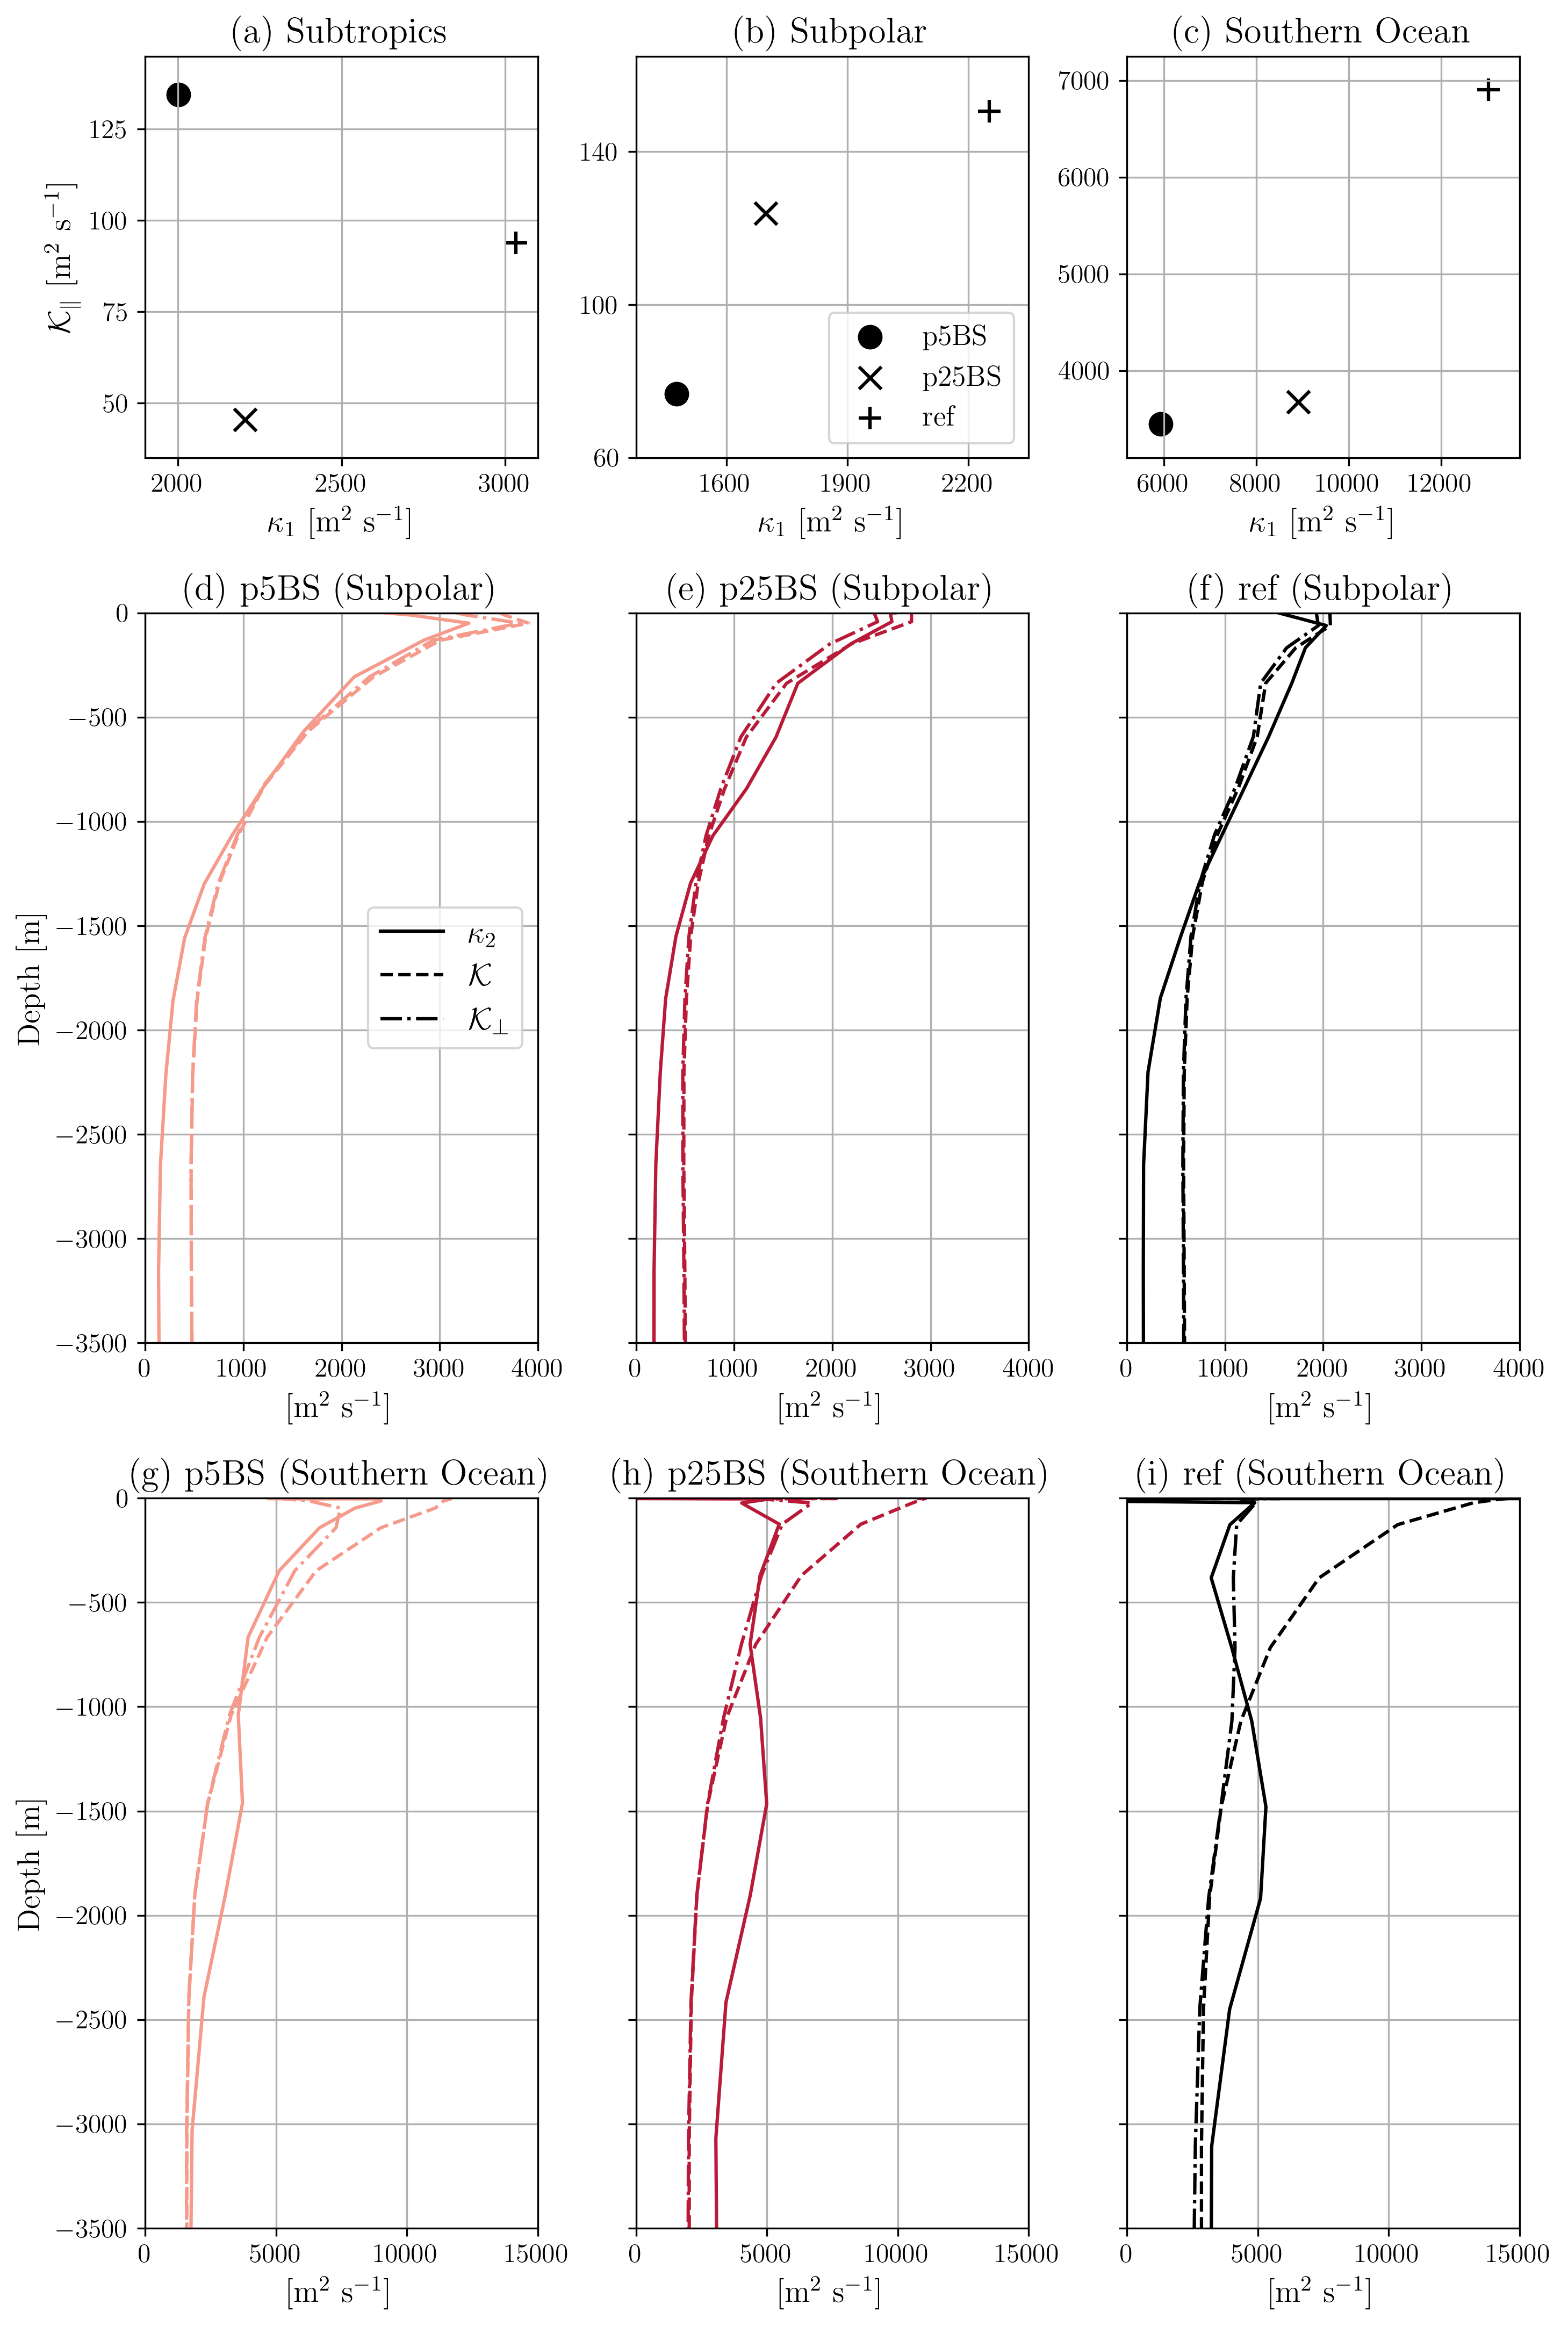

In [51]:
import matplotlib.lines as mlines
fig = plt.figure(figsize = (11, 17.5), dpi = 300)
gs = gridspec.GridSpec(3, 3, figure = fig, height_ratios = [0.55, 1, 1], hspace = 0.25, wspace = 0.25)

fontsize = 14
linewidth = 1.5
markersize = 100

# Top row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
# Middle row
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
# Bottom row
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

# Shear dispersion
ax = ax1
ax.scatter(p5_SQGBS_kappa1_SubTrop.mean(), p5_SQGBS_kappaSD_SubTrop.mean(), color = 'k', marker = 'o', s = markersize, label = 'p5BS')
ax.scatter(p25_SQGBS_kappa1_SubTrop.mean(), p25_SQGBS_kappaSD_SubTrop.mean(), color = 'k', marker = 'x', s = markersize, label = 'p25BS')
ax.scatter(p03125_kappa1_SubTrop.mean(), p03125_kappaSD_SubTrop.mean(), color = 'k', marker = '+', s = markersize, label = 'ref')
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.set_ylabel('$\mathcal{K}_{\parallel}$ [m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_xlabel('$\kappa_1$ [m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(a) Subtropics', fontsize = fontsize + 2)
ax.grid()
ax.set_xlim([1900, 3100])
ax.set_xticks(np.linspace(2000, 3000, 3))
ax.set_ylim([35, 145])
ax.set_yticks(np.linspace(50, 125, 4))

ax = ax2
ax.scatter(p5_SQGBS_kappa1_SubPol.mean(), p5_SQGBS_kappaSD_SubPol.mean(), color = 'k', marker = 'o', s = markersize, label = 'p5BS')
ax.scatter(p25_SQGBS_kappa1_SubPol.mean(), p25_SQGBS_kappaSD_SubPol.mean(), color = 'k', marker = 'x', s = markersize, label = 'p25BS')
ax.scatter(p03125_kappa1_SubPol.mean(), p03125_kappaSD_SubPol.mean(), color = 'k', marker = '+', s = markersize, label = 'ref')
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.set_ylabel('')
ax.set_xlabel('$\kappa_1$ [m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(b) Subpolar', fontsize = fontsize + 2)
ax.grid()
ax.legend(fontsize = fontsize - 1, loc = 'lower right')
ax.set_xlim([1375, 2350])
ax.set_xticks(np.linspace(1600, 2200, 3))
ax.set_ylim([60, 165])
ax.set_yticks(np.linspace(60, 140, 3))

ax = ax3
ax.scatter(p5_SQGBS_kappa1_ACC.mean(), p5_SQGBS_kappaSD_ACC.mean(), color = 'k', marker = 'o', s = markersize, label = 'p5BS')
ax.scatter(p25_SQGBS_kappa1_ACC.mean(), p25_SQGBS_kappaSD_ACC.mean(), color = 'k', marker = 'x', s = markersize, label = 'p25BS')
ax.scatter(p03125_kappa1_ACC.mean(), p03125_kappaSD_ACC.mean(), color = 'k', marker = '+', s = markersize, label = 'ref')
ax.tick_params(axis = 'both', labelsize = fontsize - 2)
ax.set_ylabel('')
ax.set_xlabel('$\kappa_1$ [m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(c) Southern Ocean', fontsize = fontsize + 2)
ax.grid()
ax.set_xlim([5200, 13700])
ax.set_xticks(np.linspace(6000, 12000, 4))
ax.set_ylim([3100, 7250])
ax.set_yticks(np.linspace(4000, 7000, 4))

## Mean flow suppression
# subpolar
slice_func = SubPol_slice

ax = ax4
res = 0.5
h = slice_func(p5_SQGBS_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

ax.plot((p5_SQGBS_kappa2_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '-')
ax.plot((p5_SQGBS_MLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '--')
ax.plot((p5_SQGBS_SMLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('Depth [m]', fontsize = fontsize)
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(d) p5BS (Subpolar)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 4000])
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

line1 = mlines.Line2D([], [], color = 'k', linestyle = '-', linewidth = linewidth, label = r'$\kappa_2$')
line2 = mlines.Line2D([], [], color = 'k', linestyle = '--', linewidth = linewidth, label = '$\mathcal{K}$')
line3 = mlines.Line2D([], [], color = 'k', linestyle = '-.', linewidth = linewidth, label = '$\mathcal{K}_\perp$')

ax4.legend(handles = [line1, line2, line3], loc = 'center right', fontsize = fontsize)

ax = ax5
res = 0.25
h = slice_func(p25_SQGBS_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

ax.plot((p25_SQGBS_kappa2_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '-')
ax.plot((p25_SQGBS_MLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '--')
ax.plot((p25_SQGBS_SMLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_SubPol.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('')
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(e) p25BS (Subpolar)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 4000])
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

ax = ax6
ax.plot((p03125_kappa2_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_SubPol.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '-')
ax.plot((p03125_MLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_SubPol.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '--')
ax.plot((p03125_SMLT_SubPol * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_SubPol.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('')
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(f) ref (Subpolar)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 4000])
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

# subpolar
slice_func = ACC_slice

ax = ax7
res = 0.5
h = slice_func(p5_SQGBS_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

ax.plot((p5_SQGBS_kappa2_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '-')
ax.plot((p5_SQGBS_MLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '--')
ax.plot((p5_SQGBS_SMLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p5_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p5[1], linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('Depth [m]', fontsize = fontsize)
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(g) p5BS (Southern Ocean)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 15000])
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

ax = ax8
res = 0.25
h = slice_func(p25_SQGBS_h).coarsen(xh = int(2 / res), yh = int(2 / res), boundary = 'exact').mean()

ax.plot((p25_SQGBS_kappa2_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '-')
ax.plot((p25_SQGBS_MLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '--')
ax.plot((p25_SQGBS_SMLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p25_SQGBS_z_ACC.mean(['xh', 'yh']), color = colorlist_p25[1], linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('')
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(h) p25BS (Southern Ocean)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 15000])
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

ax = ax9

ax.plot((p03125_kappa2_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_ACC.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '-')
ax.plot((p03125_MLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_ACC.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '--')
ax.plot((p03125_SMLT_ACC * h).sum(['xh', 'yh']) / h.sum(['xh', 'yh']), p03125_z_ACC.mean(['xh', 'yh']), color = 'k', linewidth = linewidth, linestyle = '-.')

ax.grid()
ax.set_ylabel('')
ax.set_xlabel('[m$^2$ s$^{-1}$]', fontsize = fontsize)
ax.set_title('(i) ref (Southern Ocean)', fontsize = fontsize + 2)
ax.set_ylim([-3500, 0])
ax.set_xlim([0, 15000])
ax.tick_params(labelleft = False)
ax.tick_params(axis = 'both', labelsize = fontsize - 2)

plt.savefig('Fig_shear_disp_mix_suppress.pdf', bbox_inches = 'tight', dpi = 300)